- Compare HSI emissions with Climate TRACE inventory and available literatural observation results

In [1]:
import os
from glob import glob
from itertools import chain
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import string
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import leafmap.foliumap as leafmap

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

## Read data

In [3]:
# --- summary data ---
df_summary = pd.read_csv('../data/landfills_hyper_summary.csv', dtype={'metadata_report_year': str})
# units: t/h
# df_summary['emission'] = df_summary['emission']
# convert units from t/yr to t/h
df_summary['emissions_quantity'] /= (365*24)

# --- climate trace top 20 ---
df_climatetrace = pd.read_excel('../data/landfills_hyper_obs.xlsx', dtype={'metadata_report_year': str}, sheet_name='ClimateTrace_TOP20')
# convert units from t/yr to t/h
df_climatetrace['emissions_quantity'] /= (365*24)

# --- all HSI plume OBS ---
df_hyper_top20 = pd.read_excel('../data/landfills_hyper_obs.xlsx', sheet_name='ClimateTrace_TOP20')
# remove space at end
df_hyper_top20['name'] = df_hyper_top20['name'].str.strip()

# --- ground OBS data ---
df_obs = pd.read_excel('../data/landfills_hyper_obs.xlsx', dtype={'year': str}, sheet_name='OBS')
# units:t/h
df_obs['emission_obs'] = df_obs['emission(t/h)'] #/ 1e3 * 365 *24
df_obs['uncertainty_obs'] = df_obs['uncertainty(t/h)'] #/ 1e3 * 365 *24

# --- city emission ---
df_city = pd.read_excel('../data/landfills_hyper_obs.xlsx', dtype={'year': str}, sheet_name='Country_City')
# convert units from t/yr to t/h
df_city['ClimateTrace'] /= (365*24)
df_city['ClimateTrace_total'] /= (365*24)
df_city['WasteMAP'] /= (365*24)


## Overview Folium Map

In [4]:
m = leafmap.Map()
m.add_basemap("Esri.WorldImagery")

# m.add_circle_markers_from_xy(geo_df_large, x="lon", y="lat", radius=5, color="none", fill_color='blue', fill_opacity=0.6, popup=['lon', 'lat', 'emissions_quantity', 'asset_name', 'iso3_country', 'start_time', 'end_time'])
m.add_circle_markers_from_xy(df_summary[['longitude', 'latitude', 'name']].dropna(), x="longitude", y="latitude", radius=5, color="none", fill_color='blue', fill_opacity=0.6,
                             popup=['longitude', 'latitude', 'name'],
                             max_width=500)

In [5]:
m.to_html('../figures/hyper.html')

## Merge HSI and Climate TRACE data

In [6]:
df_merge = df_summary.groupby(['country', 'name'], as_index=False)\
                     .agg({'emission':'mean', 'emission_uncertainty(%)': 'mean',
                           'emissions_quantity': 'mean',
                           'emissions_factor':'mean', 'capacity':'mean', 'activity':'mean', 'plume_count': 'sum',
                           'metadata_source': 'first', 'metadata_report_year': 'first',
                           })

# calculate uncertainty
df_merge['emission_uncertainty(t/h)'] = df_merge['emission']*df_merge['emission_uncertainty(%)']*1e-2

# only keep row which has climate trace data
df_merge_ct = df_merge.dropna(subset=['emissions_quantity'])

# rename column names
df_merge_ct = df_merge_ct[['country', 'name', 'emission', 'emissions_quantity', 'emission_uncertainty(t/h)', 'plume_count', 'metadata_source', 'metadata_report_year']]\
      .rename(columns={'country': 'Country', 'name': 'Name', 'emission': 'HSI', 'emission_uncertainty(t/h)': 'HSI uncertainty (t h$^{-1}$)',
                       'emissions_quantity': 'Climate TRACE', 'metadata_source': 'Report Source', 'metadata_report_year': 'Report Year'})
df_merge_ct['Report Year'] = df_merge_ct['Report Year'].str.rstrip('.0')

In [7]:
df_merge_ct['HSI/ClimateTRACE'] = ((df_merge_ct['HSI']-df_merge_ct['Climate TRACE'])/df_merge_ct['Climate TRACE']).round(1)

In [8]:
df_2021_2022 = df_merge_ct[df_merge_ct['Report Year'].isin(['2021', '2022'])]
# df_2021_2022['HSI'].sum() / df_2021_2022['Climate TRACE'].sum()
(df_2021_2022['HSI'].sum() - df_2021_2022['Climate TRACE'].sum()) / df_2021_2022['Climate TRACE'].sum()

1.2977380392790856

In [9]:
df_merge_ct.sort_values('HSI/ClimateTRACE', ascending=False)

,Country,Name,HSI,Climate TRACE,HSI uncertainty (t h$^{-1}$),plume_count,Report Source,Report Year,HSI/ClimateTRACE
7,India,Bandhwari,2.553434,0.015812,0.900487,4,Global Plastic Watch,2021,160.5
13,India,Majura,6.538458,0.173664,2.133886,3,Global Plastic Watch,2021,36.6
12,India,Kanjurmarg,9.985372,0.442059,3.214574,4,Global Plastic Watch,2021,21.6
14,India,Manter Wadi,3.988464,0.283659,1.575537,1,Global Plastic Watch,2021,13.1
11,India,Kachara,3.199851,0.349474,1.408391,1,Global Plastic Watch,2021,8.2
1,Argentina,Norte III,19.519923,3.256637,5.871889,8,Waste Atlas,2013,5.0
31,Saudi Arabia,Riyadh,10.900393,1.877095,3.286874,11,METER/OSM,2022,4.8
34,United States,Charlotte Motor Speedway,4.213338,0.733782,1.783368,3,EPA GHGRP,2021,4.7
3,Bangladesh,Aminbazar,6.878776,1.541889,2.528361,1,METER/OSM,2022,3.5
23,Kuwait,Kabd,6.125735,1.526076,1.911111,10,METER/OSM,2022,3.0


In [10]:
df_merge_ct_format = df_merge_ct.round(decimals=1)
df_merge_ct_format['HSI'] = df_merge_ct_format['HSI'].astype(str) + ' $\pm$ ' + df_merge_ct_format['HSI uncertainty (t h$^{-1}$)'].astype(str)
# # print latex table
print(df_merge_ct_format.drop(['plume_count', 'HSI uncertainty (t h$^{-1}$)', 'HSI/ClimateTRACE'], axis=1).to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{lllrll}
\toprule
Country & Name & HSI & Climate TRACE & Report Source & Report Year \\
\midrule
Argentina & González Catán & 2.9 $\pm$ 1.0 &        2.2 & Waste Atlas & 2013 \\
Argentina & Norte III & 19.5 $\pm$ 5.9 &        3.3 & Waste Atlas & 2013 \\
Argentina & Piedra Blanca & 2.7 $\pm$ 1.1 &        1.7 & METER/OSM & 2022 \\
Bangladesh & Aminbazar & 6.9 $\pm$ 2.5 &        1.5 & METER/OSM & 2022 \\
India & Bandhwari & 2.6 $\pm$ 0.9 &        0.0 & Global Plastic Watch & 2021 \\
India & Bhalswa & 2.0 $\pm$ 0.8 &        1.4 & Waste Atlas & 2013 \\
India & Deonar & 2.5 $\pm$ 1.2 &        2.4 & Waste Atlas & 2013 \\
India & Ghazipur & 4.7 $\pm$ 1.6 &        2.0 & Waste Atlas & 2013 \\
India & Kachara & 3.2 $\pm$ 1.4 &        0.3 & Global Plastic Watch & 2021 \\
India & Kanjurmarg & 10.0 $\pm$ 3.2 &        0.4 & Global Plastic Watch & 2021 \\
India & Majura & 6.5 $\pm$ 2.1 &        0.2 & Global Plastic Watch & 2021 \\
India & Manter Wadi & 4.0 $\pm$ 1.6 &        0.3 & Global

In [11]:
# # print latex table
# print(df_merge_ct.rename(columns={'HSI': 'HSI (t h$^{-1}$)', 'Climate TRACE': 'Climate TRACE (t h$^{-1}$)'}).to_latex(index=False, float_format=lambda x: '%10.1f' % x))

In [12]:
# total emission t h-1
df_merge_ct['HSI'].sum()

134.23935974297558

In [13]:
# uncertainty of total emission
np.sqrt(((df_merge_ct['HSI uncertainty (t h$^{-1}$)'])**2).sum())

10.798161651987888

In [14]:
df_merge_ct['HSI'].sum()/df_merge_ct['Climate TRACE'].sum()

1.7132865554957823

In [15]:
# the total HSI emission is ??% higher than inventory
(df_merge_ct['HSI'].sum() - df_merge_ct['Climate TRACE'].sum())/df_merge_ct['Climate TRACE'].sum()

0.7132865554957825

## Fit HSI and Climate TRACE

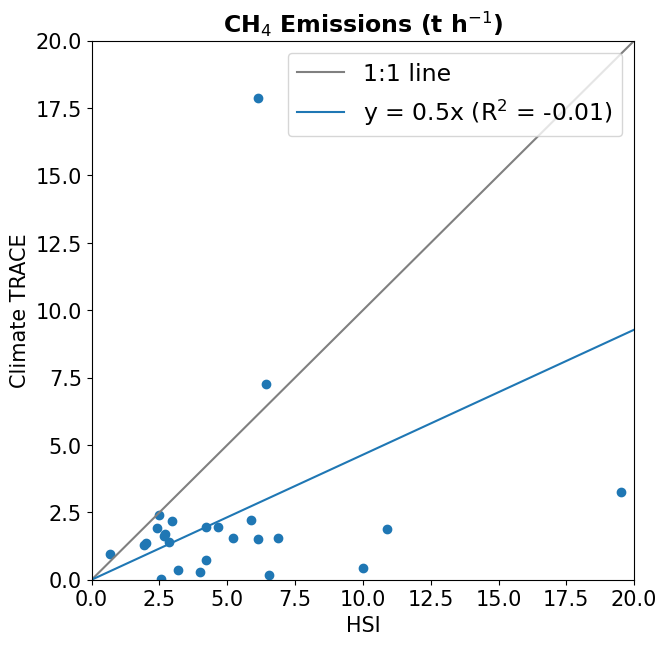

In [16]:
fig, ax = plt.subplots(figsize=(7, 7))

x = df_merge_ct['HSI'].values
xerr = df_merge_ct['HSI uncertainty (t h$^{-1}$)']
y = df_merge_ct['Climate TRACE'].values

# Reshape the arrays to 2D
x_2d = x.reshape(-1, 1)
y_2d = y.reshape(-1, 1)

# Create and fit the linear regression model
model = LinearRegression(fit_intercept=False)
model.fit(x_2d, y_2d)

# Get the slope of the linear regression line
slope = model.coef_[0][0]

# Calculate R-squared
r_squared = model.score(x_2d, y_2d)

plt.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='gray')
plt.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='C0')

ax.scatter(x, y)

ax.set_xlabel('HSI')
ax.set_ylabel('Climate TRACE')
ax.set_title('CH$_4$ Emissions (t h$^{-1}$)')

ax.set_xlim(0, 20)
ax.set_ylim(0, 20)

plt.legend()

# fig.savefig('../figures/hsi_climatetrace_fit.pdf')

## Matrix plot

In [17]:
def plot_stats(df):
    # https://stackoverflow.com/a/50690729/7347925
    def corrdot(*args, **kwargs):
        corr_r = args[0].corr(args[1], 'pearson')
        corr_text = f"{corr_r:2.2f}".replace("0.", ".")
        ax = plt.gca()
        ax.set_axis_off()
        marker_size = abs(corr_r) * 10000
        ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
                vmin=-1, vmax=1, transform=ax.transAxes)
        font_size = abs(corr_r) * 40 + 5
        ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                    ha='center', va='center', fontsize=font_size)

    sns.set(style='white', font_scale=1.6)
    g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)
    g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
    g.map_diag(sns.distplot, kde_kws={'color': 'black'})
    g.map_upper(corrdot)

In [18]:
# plot_stats(df_merge[['emission', 'emissions_quantity', 'emissions_factor', 'capacity', 'activity']])

## City emission

In [19]:
def calc_city_emiss(row, df_merge):
    if pd.notna(row['landfills']):
        names = [name.lstrip() for name in row['landfills'].split(',')]
        df_city_subset = df_merge[df_merge['name'].isin(names)]
        emiss_mean = df_city_subset['emission'].sum().item()
        emiss_std = np.sqrt((df_city_subset['emission_uncertainty(t/h)']**2).sum()).item()
        return emiss_mean, emiss_std
    else:
        return np.nan, np.nan

In [20]:
df_city['HSI'], df_city['HSI uncertainty'] = zip(*df_city.apply(calc_city_emiss, args=(df_merge,), axis=1))

In [21]:
df_merge

,country,name,emission,emission_uncertainty(%),emissions_quantity,emissions_factor,capacity,activity,plume_count,metadata_source,metadata_report_year,emission_uncertainty(t/h)
0,Argentina,González Catán,2.946672,33.974198,2.177970,0.041004,1200000.00,465297.85,5,Waste Atlas,2013.0,1.001108
1,Argentina,Norte III,19.519923,30.081516,3.256637,0.045643,900000.00,625026.97,8,Waste Atlas,2013.0,5.871889
2,Argentina,Piedra Blanca,2.709553,40.599091,1.701192,0.041850,NaN,356094.72,2,METER/OSM,2022.0,1.100054
3,Bangladesh,Aminbazar,6.878776,36.755979,1.541889,0.046725,NaN,289072.51,1,METER/OSM,2022.0,2.528361
4,Brazil,Caieiras,14.248087,36.316468,NaN,NaN,NaN,NaN,1,None,None,5.174402
5,Brazil,Pedreira,10.991205,38.411063,NaN,NaN,NaN,NaN,1,None,None,4.221839
6,China,Ürümqi,8.210699,42.648459,NaN,NaN,NaN,NaN,5,None,None,3.501737
7,India,Bandhwari,2.553434,35.265715,0.015812,0.054080,1361.51,2561.19,4,Global Plastic Watch,2021.0,0.900487
8,India,Bhalswa,2.017209,37.640534,1.377097,0.046983,161799.83,256761.58,6,Waste Atlas,2013.0,0.759288
9,India,Deonar,2.490324,46.203740,2.400635,0.053694,1325080.24,391657.52,2,Waste Atlas,2013.0,1.150623


In [22]:
df_city

,country,city,landfills,ClimateTrace,WasteMAP,ClimateTrace_total,ClimateTrace_num,coverage,HSI,HSI uncertainty
0,Argentina,All,"González Catán, Piedra Blanca, Norte III",60.283345,24.429224,60.283345,71.0,4.2,5.656225,1.487392
1,Argentina,Buenos Aires,"Norte III, González Catán",NaN,3.790068,NaN,NaN,NaN,22.466596,5.956618
2,Bangladesh,All,Aminbazar,24.487857,24.543379,1.541889,1.0,100.0,6.878776,2.528361
3,Bangladesh,Dhaka,Aminbazar,NaN,3.892009,NaN,NaN,NaN,6.878776,2.528361
4,Brazil,All,"Caieiras, Pedreira",247.759799,247.716895,205.275049,285.0,0.7,25.239292,6.678200
5,Brazil,São Paulo,"Caieiras, Pedreira",NaN,9.826712,NaN,NaN,NaN,25.239292,6.678200
6,China,All,Ürümqi,681.477749,681.506849,231.341607,592.0,0.2,8.210699,3.501737
7,India,All,"Bandhwari, Bhalswa, Deonar, Ghazipur, Kachara,...",108.917550,71.118721,108.917550,534.0,1.9,43.697232,5.466482
8,Iran,All,"Mashhad, Tehran",41.476894,16.438356,41.476894,42.0,4.8,10.503873,3.036261
9,Iran,Tehran,Tehran,NaN,1.911416,NaN,NaN,NaN,7.148717,2.657898


In [23]:
# add plume count to landfill name
for idx, landfill in enumerate(df_city['landfills']):
    if pd.notnull(landfill):
        landfill_names = landfill.split(',')#[0].strip()
        new_namelist = []
        for landfill_name in landfill_names:
            # print(landfill_name)
            new_name = landfill_name + ' ('+ str(df_merge.loc[df_merge['name'] == landfill_name.strip()]['plume_count'].item()) + ')'
            new_namelist.append(new_name)
        name_num = ','.join(new_namelist)
        df_city.loc[idx, 'landfills'] = name_num

In [24]:
df_country = df_city.groupby(['country'], as_index=False)\
    .agg({'HSI': lambda x: x.sum(min_count=1), 
          'ClimateTrace': 'max',
          'ClimateTrace_total': 'max',
          'WasteMAP': 'max',
        #   'HSI uncertainty': lambda x: np.sqrt(np.nansum(x**2)),
          'HSI uncertainty': lambda x: np.sqrt((x**2).sum(min_count=1)),
          })

In [25]:
df_country

,country,HSI,ClimateTrace,ClimateTrace_total,WasteMAP,HSI uncertainty
0,Argentina,28.122821,60.283345,60.283345,24.429224,6.139514
1,Bangladesh,13.757552,24.487857,1.541889,24.543379,3.575643
2,Brazil,50.478584,247.759799,205.275049,247.716895,9.444401
3,China,8.210699,681.477749,231.341607,681.506849,3.501737
4,India,43.697232,108.917550,108.917550,71.118721,5.466482
5,Iran,17.652590,41.476894,41.476894,16.438356,4.035257
6,Israel,11.073314,22.364848,2.693782,22.374429,2.725696
7,Jordan,15.501875,15.978632,12.282878,15.981735,3.025408
8,Kuwait,12.251470,36.672657,14.077345,36.643836,2.702718
9,Mexico,46.136552,476.626099,476.626099,222.374429,7.811007


In [26]:
# print latex table
df_city_subset = df_city[df_city['city']!='All'][['country', 'city', 'landfills', 'WasteMAP', 'HSI', 'HSI uncertainty']]\
      .rename(columns={'country': 'Country', 'city':'City', 'landfills': 'Landfills'})
df_city_subset['HSI/WasteMAP'] = np.round(df_city_subset['HSI']/df_city_subset['WasteMAP'], 1)

df_city_subset_format = df_city_subset.round(decimals=1)
df_city_subset_format['HSI'] = df_city_subset_format['HSI'].astype(str) + ' $\pm$ ' + df_city_subset_format['HSI uncertainty'].astype(str)
# # print latex table
print(df_city_subset_format.drop('HSI uncertainty', axis=1).rename(columns={'WasteMAP': 'WasteMAP (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)'}).to_latex(index=False, float_format=lambda x: '%10.1f' % x))

# print(df_city_subset.rename(columns={'WasteMAP': 'WasteMAP (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)', 'HSI uncertainty': 'HSI uncertainty (t h$^{-1}$)'})\
#     .to_latex(index=False, float_format=lambda x: '%10.1f' % x)
#     )

\begin{tabular}{lllrlr}
\toprule
Country & City & Landfills & WasteMAP (t h$^{-1}$) & HSI (t h$^{-1}$) & HSI/WasteMAP \\
\midrule
Argentina & Buenos Aires & Norte III (8), González Catán (5) &        3.8 & 22.5 $\pm$ 6.0 &        5.9 \\
Bangladesh & Dhaka & Aminbazar (1) &        3.9 & 6.9 $\pm$ 2.5 &        1.8 \\
Brazil & São Paulo & Caieiras (1), Pedreira (1) &        9.8 & 25.2 $\pm$ 6.7 &        2.6 \\
Iran & Tehran & Tehran (9) &        1.9 & 7.1 $\pm$ 2.7 &        3.7 \\
Jordan & Amman & Ghabawi (14) &        1.1 & 6.4 $\pm$ 2.0 &        5.8 \\
Kuwait & Kuwait City & Kabd (10) &       10.0 & 6.1 $\pm$ 1.9 &        0.6 \\
Mexico & Mexico City & Zumpango (1), Relleno Sanitario Peña De Gatos (3), Relleno Sanitario Bicentenario (1), Tecnosilicatos (3) &       12.5 & 16.9 $\pm$ 4.9 &        1.4 \\
Mexico & Monterrey & Simeprodeso (5) &        0.3 & 6.1 $\pm$ 2.5 &       18.1 \\
Pakistan & Lahore & Lakhodair (2) &        6.0 & 10.5 $\pm$ 3.6 &        1.7 \\
Pakistan & Karachi & Jam Ch

In [27]:
# city emission > HSI or within 10%
df_city_subset['percent_diff'] = (df_city_subset['HSI']-df_city_subset['WasteMAP']) / df_city_subset['WasteMAP'] * 100
df_city_subset[(df_city_subset['percent_diff']<0) | (np.abs(df_city_subset['percent_diff'])<10)]

,Country,City,Landfills,WasteMAP,HSI,HSI uncertainty,HSI/WasteMAP,percent_diff
14,Kuwait,Kuwait City,Kabd (10),10.044406,6.125735,1.911111,0.6,-39.013471
20,Pakistan,Karachi,Jam Chakro (1),5.303539,4.231926,1.519279,0.8,-20.205617
22,Saudi Arabia,Riyadh,Riyadh (11),11.811644,10.900393,3.286874,0.9,-7.714852
31,Yemen,Sanaa,Al-Azraqin (1),1.589155,0.668858,0.220347,0.4,-57.911116


In [28]:
df_city_subset['HSI/WasteMAP'].mean()

5.673333333333333

In [29]:
df_city_subset.sort_values('HSI/WasteMAP')

,Country,City,Landfills,WasteMAP,HSI,HSI uncertainty,HSI/WasteMAP,percent_diff
31,Yemen,Sanaa,Al-Azraqin (1),1.589155,0.668858,0.220347,0.4,-57.911116
14,Kuwait,Kuwait City,Kabd (10),10.044406,6.125735,1.911111,0.6,-39.013471
20,Pakistan,Karachi,Jam Chakro (1),5.303539,4.231926,1.519279,0.8,-20.205617
22,Saudi Arabia,Riyadh,Riyadh (11),11.811644,10.900393,3.286874,0.9,-7.714852
16,Mexico,Mexico City,"Zumpango (1), Relleno Sanitario Peña De Gatos ...",12.502283,16.934724,4.935878,1.4,35.453054
19,Pakistan,Lahore,Lakhodair (2),5.994749,10.452923,3.609022,1.7,74.367988
3,Bangladesh,Dhaka,Aminbazar (1),3.892009,6.878776,2.528361,1.8,76.741000
5,Brazil,São Paulo,"Caieiras (1), Pedreira (1)",9.826712,25.239292,6.678200,2.6,156.843706
29,Uzbekistan,Tashkent,Akhangaran (8),0.935845,3.261518,1.290865,3.5,248.510613
9,Iran,Tehran,Tehran (9),1.911416,7.148717,2.657898,3.7,274.001194


In [30]:
df_country['HSI/ClimateTrace'] = df_country['HSI'] / df_country['ClimateTrace']
df_country['HSI/ClimateTrace(%)'] = df_country['HSI/ClimateTrace'] * 100
df_country['percent_diff'] = (df_country['HSI']-df_country['ClimateTrace']) / df_country['ClimateTrace'] * 100
df_country['percent_diff_facility_total'] = (df_country['ClimateTrace_total']-df_country['HSI']) / df_country['HSI'] * 100

In [31]:
# how much facility-level estimations lower than the country emissions
df_country[df_country['percent_diff_facility_total']<0]['percent_diff_facility_total'].mean()

-53.05289815449767

In [32]:
df_country.dropna(subset=['HSI', 'ClimateTrace']).sort_values('HSI/ClimateTrace')

,country,HSI,ClimateTrace,ClimateTrace_total,WasteMAP,HSI uncertainty,HSI/ClimateTrace,HSI/ClimateTrace(%),percent_diff,percent_diff_facility_total
14,United States,7.077859,690.356070,690.356070,414.269406,1.981743,0.010252,1.025248,-98.974752,9653.741585
3,China,8.210699,681.477749,231.341607,681.506849,3.501737,0.012048,1.204837,-98.795163,2717.562776
9,Mexico,46.136552,476.626099,476.626099,222.374429,7.811007,0.096798,9.679821,-90.320179,933.076989
16,Yemen,1.337715,11.331236,0.960326,11.301370,0.311618,0.118056,11.805556,-88.194444,-28.211451
12,Spain,10.395878,52.487856,17.251027,56.621005,2.782265,0.198063,19.806254,-80.193746,65.941030
2,Brazil,50.478584,247.759799,205.275049,247.716895,9.444401,0.203740,20.374001,-79.625999,306.657699
15,Uzbekistan,6.523037,21.065895,13.383096,21.118721,1.825559,0.309649,30.964916,-69.035084,105.166655
8,Kuwait,12.251470,36.672657,14.077345,36.643836,2.702718,0.334076,33.407641,-66.592359,14.903315
11,Saudi Arabia,21.800786,59.444557,8.662748,59.474886,4.648342,0.366742,36.674150,-63.325850,-60.264058
4,India,43.697232,108.917550,108.917550,71.118721,5.466482,0.401196,40.119551,-59.880449,149.255033


In [33]:
df_country_format = df_country.round(decimals=1)
df_country_format['HSI'] = df_country_format['HSI'].astype(str) + ' $\pm$ ' + df_country_format['HSI uncertainty'].astype(str)
# # print latex table
print(df_country_format.drop('HSI uncertainty', axis=1)[['country', 'ClimateTrace', 'HSI', 'HSI/ClimateTrace(%)']].dropna(subset=['HSI', 'ClimateTrace'])\
      .rename(columns={'country': 'Country', 'ClimateTrace': 'Climate TRACE (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)'})\
        .to_latex(index=False, float_format=lambda x: '%10.1f' % x))
      

# print(df_country[['country', 'ClimateTrace', 'HSI', 'HSI uncertainty']].dropna(subset=['HSI', 'ClimateTrace'])\
#       .rename(columns={'country': 'Country', 'ClimateTrace': 'Climate TRACE (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)', 'HSI uncertainty': 'HSI uncertainty (t h$^{-1}$)'})\
#         .to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{lrlr}
\toprule
Country & Climate TRACE (t h$^{-1}$) & HSI (t h$^{-1}$) & HSI/ClimateTrace(%) \\
\midrule
Argentina &       60.3 & 28.1 $\pm$ 6.1 &       46.7 \\
Bangladesh &       24.5 & 13.8 $\pm$ 3.6 &       56.2 \\
Brazil &      247.8 & 50.5 $\pm$ 9.4 &       20.4 \\
China &      681.5 & 8.2 $\pm$ 3.5 &        1.2 \\
India &      108.9 & 43.7 $\pm$ 5.5 &       40.1 \\
Iran &       41.5 & 17.7 $\pm$ 4.0 &       42.6 \\
Israel &       22.4 & 11.1 $\pm$ 2.7 &       49.5 \\
Jordan &       16.0 & 15.5 $\pm$ 3.0 &       97.0 \\
Kuwait &       36.7 & 12.3 $\pm$ 2.7 &       33.4 \\
Mexico &      476.6 & 46.1 $\pm$ 7.8 &        9.7 \\
Pakistan &       55.3 & 29.4 $\pm$ 5.5 &       53.1 \\
Saudi Arabia &       59.4 & 21.8 $\pm$ 4.6 &       36.7 \\
Spain &       52.5 & 10.4 $\pm$ 2.8 &       19.8 \\
Tunisia &       10.3 & 11.2 $\pm$ 2.8 &      108.4 \\
United States &      690.4 & 7.1 $\pm$ 2.0 &        1.0 \\
Uzbekistan &       21.1 & 6.5 $\pm$ 1.8 &       31.0 \\
Yemen &     

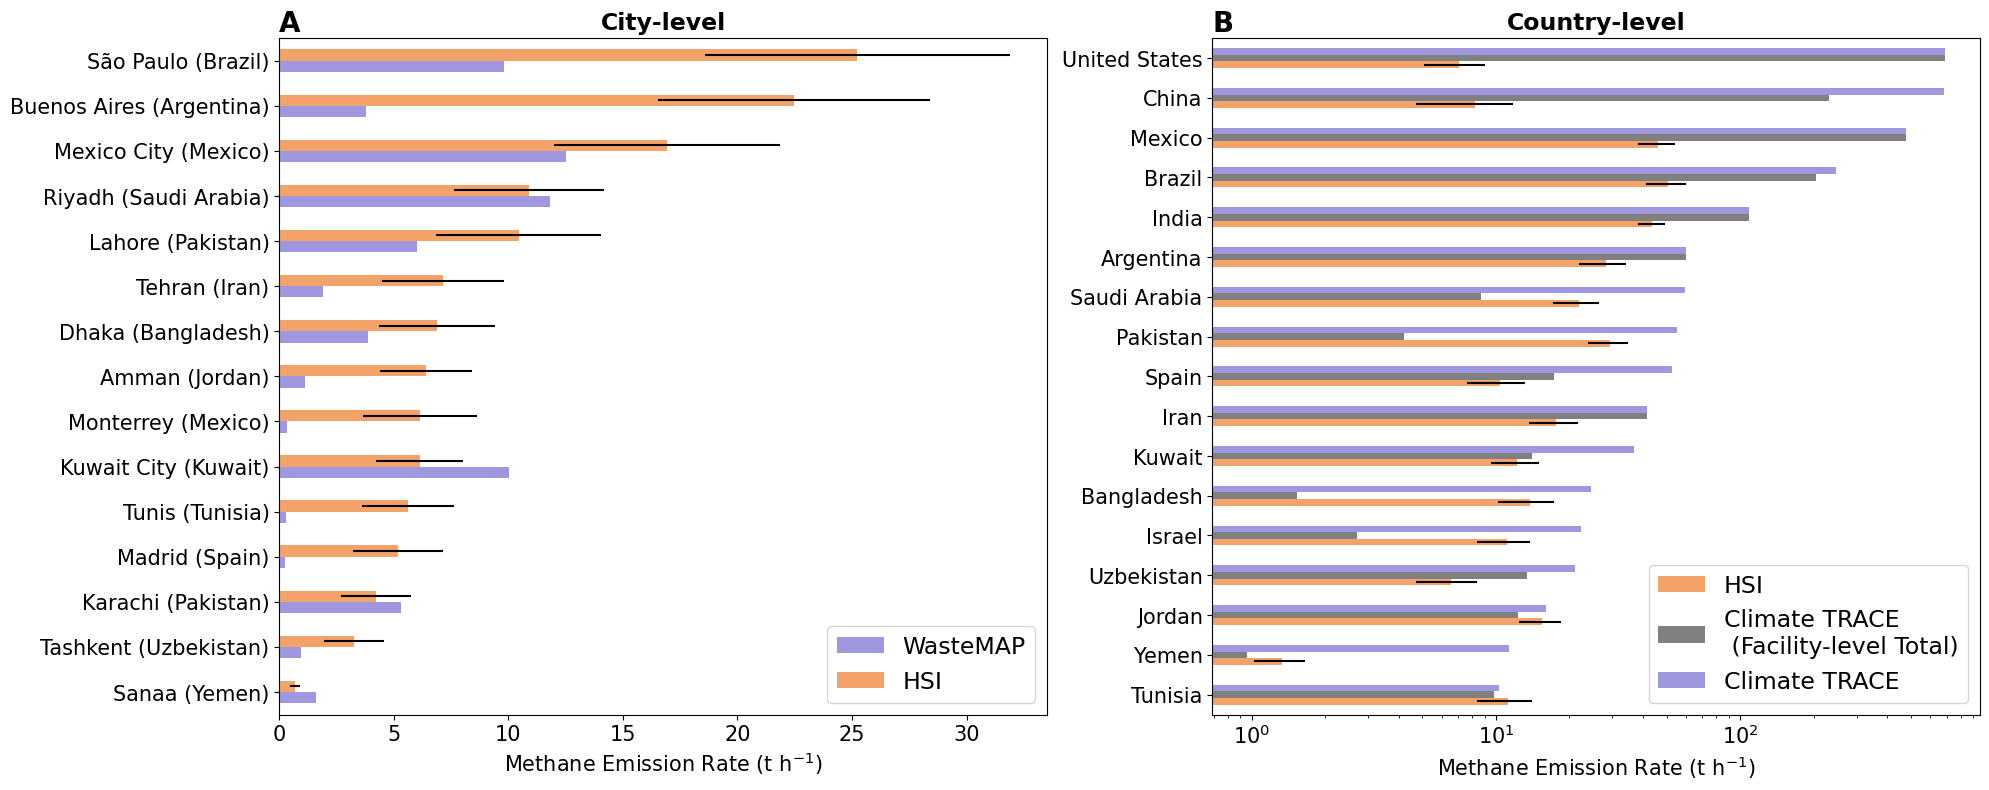

In [34]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

axs = axs.flatten()

ax = axs[0]

# sort by HSI emission
df_city_subset_sort = df_city_subset.sort_values('HSI')
# set city name
df_city_subset_sort['City'] = df_city_subset_sort['City'] + ' (' + df_city_subset_sort['Country'] + ')'

df_city_subset_sort.plot(ax=ax,
                        x='City', y=['WasteMAP', 'HSI'],
                        xerr=[[0]*len(df_city_subset),
                        df_city_subset_sort['HSI uncertainty'],      
                              ],
                        kind="barh",
                        color=['#9f98de', '#f3a26a']
                        )
ax.set_title('City-level')
ax.set_ylabel('')
ax.set_xlabel('Methane Emission Rate (t h$^{-1}$)')


ax = axs[1]

df_country_sort = df_country.dropna(subset=['HSI', 'ClimateTrace']).sort_values('ClimateTrace')\
                            .rename(columns={'ClimateTrace': 'Climate TRACE',
                                             'ClimateTrace_total': 'Climate TRACE \n (Facility-level Total)'})

df_country_sort.plot(ax=ax,
                        x='country',
                        y=['HSI', 'Climate TRACE \n (Facility-level Total)', 'Climate TRACE'],
                        xerr=[df_country_sort['HSI uncertainty'], 
                              [0]*len(df_country_sort),
                              [0]*len(df_country_sort),
                                   
                              ],
                        kind="barh",
                        color=['#f3a26a', 'gray', '#9f98de']
                        )

ax.set_xscale('log')
ax.set_title('Country-level')
ax.set_ylabel('')
ax.set_xlabel('Methane Emission Rate (t h$^{-1}$)')


for n, ax in enumerate(axs):
    # plot wind quivers
    ax.text(0, 1.01, string.ascii_uppercase[n],
            transform=ax.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
fig.savefig('../figures/emission_comp_city.pdf')

## OBS

In [35]:
df_merge_obs = df_obs.merge(df_merge[['name', 'emission', 'emission_uncertainty(%)', 'emission_uncertainty(t/h)']], on='name', how='left')

# keep landfills which have both HSI and OBS
df_merge_obs_nonan = df_merge_obs.dropna(subset=['emission_obs', 'emission']).reset_index(drop=True)

In [36]:
df_merge_obs_nonan

,country,name,latitude,longitude,emission(t/h),uncertainty(t/h),year,source,Reference,Unnamed: 9,emission_obs,uncertainty_obs,emission,emission_uncertainty(%),emission_uncertainty(t/h)
0,Argentina,Norte III,-34.529123,-58.622229,21.90,7.80,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,21.90,7.80,19.519923,30.081516,5.871889
1,Bangladesh,Aminbazar,23.798009,90.299357,2.17,NaN,2021,In-situ,https://doi.org/10.1016/j.cscee.2023.100302,NaN,2.17,NaN,6.878776,36.755979,2.528361
2,India,Ghazipur,28.623779,77.327769,1.60,1.10,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,1.60,1.10,4.652700,34.900735,1.623827
3,India,Kanjurmarg,19.123219,72.953469,6.40,4.00,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,6.40,4.00,9.985372,32.192829,3.214574
4,Iran,Tehran,35.458738,51.330033,5.00,1.00,2022,EMIT,https://doi.org/10.1126/sciadv.adh2391,NaN,5.00,1.00,7.148717,37.180068,2.657898
5,Pakistan,Lakhodair,31.625742,74.417881,7.10,3.10,2020,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,7.10,3.10,10.452923,34.526434,3.609022
6,Spain,Pinto,40.258962,-3.635696,6.57,0.93,2018,In-situ,https://doi.org/10.5194/acp-22-295-2022,NaN,6.57,0.93,5.197939,37.848821,1.967359
7,United States,Charlotte Motor Speedway,35.339296,-80.658488,0.88,0.30,2022,AVIRIS-NG,CarbonMapper,NaN,0.88,0.30,4.213338,42.326731,1.783368
8,United States,Seminole Road,33.662314,-84.257714,0.50,0.37,2022,ASU GAO,CarbonMapper,NaN,0.50,0.37,2.864521,30.170303,0.864235


In [37]:
# df_merge_obs_nonan['emission_uncertainty(t/h)'] = df_merge_obs_nonan['emission'] * df_merge_obs_nonan['emission_uncertainty(%)'] *1e-2

df_merge_obs_nonan_format = df_merge_obs_nonan.round(decimals=1)
df_merge_obs_nonan_format['emission'] = df_merge_obs_nonan_format['emission'].astype(str) + ' $\pm$ ' + df_merge_obs_nonan_format['emission_uncertainty(t/h)'].astype(str)
df_merge_obs_nonan_format['emission_obs'] = df_merge_obs_nonan_format['emission_obs'].astype(str) + ' $\pm$ ' + df_merge_obs_nonan_format['uncertainty_obs'].astype(str)
df_merge_obs_nonan_format['latitude'] = df_merge_obs_nonan['latitude'].round(4).astype(str)
df_merge_obs_nonan_format['longitude'] = df_merge_obs_nonan['longitude'].round(4).astype(str)

# # print latex table
print(df_merge_obs_nonan_format.rename(columns={'country': 'Country', 'name': 'Name', 'latitude': 'Latitude', 'longitude': 'Longitude',
                                    'emission': 'HSI (t h$^{-1}$)', 'emission_obs': 'OBS (t h$^{-1}$)',
                                    'year': 'OBS report year', 'source': 'OBS source'
                                    }
                                    )[['Country', 'Name', 'Latitude', 'Longitude', 'HSI (t h$^{-1}$)', 'OBS (t h$^{-1}$)',
                                       'OBS report year', 'OBS source',
                                    ]].fillna('-').to_latex(index=False, float_format=lambda x: '%10.1f' % x))

# print(df_merge_obs_nonan.rename(columns={'country': 'Country', 'name': 'Name', 'latitude': 'Latitude', 'longitude': 'Longitude',
#                                     'emission': 'HSI (t h$^{-1}$)', 'emission_uncertainty(t/h)': 'HSI uncertainty (t h$^{-1}$)',
#                                     'emission_obs': 'OBS (t h$^{-1}$)', 'uncertainty_obs': 'OBS uncertainty (t h$^{-1}$)',
#                                     'year': 'OBS report year', 'source': 'OBS source'
#                                     }
#                                     )[['Country', 'Name', 'Latitude', 'Longitude', 'HSI (t h$^{-1}$)', 'OBS (t h$^{-1}$)',
#                                        'HSI uncertainty (t h$^{-1}$)', 'OBS uncertainty (t h$^{-1}$)', 'OBS report year', 'OBS source',
#                                     ]].fillna('-').to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{llllllll}
\toprule
Country & Name & Latitude & Longitude & HSI (t h$^{-1}$) & OBS (t h$^{-1}$) & OBS report year & OBS source \\
\midrule
Argentina & Norte III & -34.5291 & -58.6222 & 19.5 $\pm$ 5.9 & 21.9 $\pm$ 7.8 & 2021 & GHGSat \\
Bangladesh & Aminbazar & 23.798 & 90.2994 & 6.9 $\pm$ 2.5 & 2.2 $\pm$ nan & 2021 & In-situ \\
India & Ghazipur & 28.6238 & 77.3278 & 4.7 $\pm$ 1.6 & 1.6 $\pm$ 1.1 & 2021 & GHGSat \\
India & Kanjurmarg & 19.1232 & 72.9535 & 10.0 $\pm$ 3.2 & 6.4 $\pm$ 4.0 & 2021 & GHGSat \\
Iran & Tehran & 35.4587 & 51.33 & 7.1 $\pm$ 2.7 & 5.0 $\pm$ 1.0 & 2022 & EMIT \\
Pakistan & Lakhodair & 31.6257 & 74.4179 & 10.5 $\pm$ 3.6 & 7.1 $\pm$ 3.1 & 2020 & GHGSat \\
Spain & Pinto & 40.259 & -3.6357 & 5.2 $\pm$ 2.0 & 6.6 $\pm$ 0.9 & 2018 & In-situ \\
United States & Charlotte Motor Speedway & 35.3393 & -80.6585 & 4.2 $\pm$ 1.8 & 0.9 $\pm$ 0.3 & 2022 & AVIRIS-NG \\
United States & Seminole Road & 33.6623 & -84.2577 & 2.9 $\pm$ 0.9 & 0.5 $\pm$ 0.4 & 2022 & ASU GAO \

## Climate Trace top 20 landfills

### Validate csv and excel files

In [38]:
def validate_name(df_emiss, df):
    csv_name = df_emiss['name'].drop_duplicates()
    excel_name = df['name'].drop_duplicates()
    name_valid = csv_name.isin(excel_name)
    if all(name_valid):
        print('All csv landfill names are in the excel file')
    else:
        print(csv_name[~name_valid], 'is not in the excel file')

def append_excel_data(row, df):
    count = df[df['name']==row['name']][f"plume({row['platform'].lower()})"].item()
    overpass = df[df['name']==row['name']][f"overpass({row['platform'].lower()})"].item()

    return int(count), int(overpass)

In [39]:
top20_dir = '../data/Hyper_ClimateTrace20/'

filelist = list(chain(*[glob(os.path.join(top20_dir, '**', '*csv'), recursive=True)]))

df_top20 = pd.concat((pd.read_csv(f) for f in filelist), ignore_index=True)

# add shape error
df_top20['emission_uncertainty'] = np.sqrt(df_top20['emission_uncertainty']**2+(df_top20['emission']*0.05)**2)
df_top20['emission_uncertainty(%)'] = df_top20['emission_uncertainty']/df_top20['emission']*100
# convert units from kg/h to t/h
df_top20['emission_uncertainty'] /= 1e3
df_top20['emission'] /= 1e3

df_top20_emiss = df_top20.groupby(['country', 'name', 'platform'], as_index=False)\
    .agg({'plume_longitude':'mean', 'plume_latitude':'mean', 'emission':'mean',
          'emission_uncertainty(%)': 'mean', 'plume_id': 'count'})\
    .rename(columns={'plume_id': 'plume_count', 'emission_uncertainty':'emission_uncertainty(t/h)'})

# remove space at end
df_top20_emiss['name'] = df_top20_emiss['name'].str.strip()

In [40]:
validate_name(df_top20_emiss, df_hyper_top20)

All csv landfill names are in the excel file


In [41]:
df_top20_emiss['count'], df_top20_emiss['overpass'] = zip(*df_top20_emiss.apply(append_excel_data, args=(df_hyper_top20,), axis=1))

# this should be empty
df_top20_emiss.query('plume_count != count')

,country,name,platform,plume_longitude,plume_latitude,emission,emission_uncertainty(%),plume_count,count,overpass


### Calculate mean emission and add Climate TRACE data

In [42]:
# assume 0 emission for no plume
df_top20_emiss['emission_mean'] = df_top20_emiss['emission']*df_top20_emiss['plume_count']/df_top20_emiss['overpass']
df_top20_emiss['emission_ratio'] = df_top20_emiss['emission_mean']/df_top20_emiss['emission']

In [43]:
df_top20_emiss

,country,name,platform,plume_longitude,plume_latitude,emission,emission_uncertainty(%),plume_count,count,overpass,emission_mean,emission_ratio
0,Chile,Loma Los Colorados,EMIT,-70.796158,-32.956992,10.528896,40.187891,2,2,2,10.528896,1.0
1,China,West New Territories,EMIT,113.933134,22.418820,4.191561,39.494888,1,1,1,4.191561,1.0
2,China,West New Territories,EnMAP,113.932698,22.419768,5.160208,31.571051,1,1,1,5.160208,1.0
3,Greece,Fyli,EMIT,23.649191,38.074633,19.211498,36.279417,1,1,2,9.605749,0.5
4,Iran,Tehran,EMIT,51.330151,35.458524,7.148717,37.180068,9,9,9,7.148717,1.0
5,Jordan,Ghabawi,EMIT,36.189041,31.930271,6.413196,31.394613,14,14,14,6.413196,1.0
6,Mexico,Los Laureles,PRISMA,-103.175072,20.546055,4.106266,40.563031,1,1,1,4.106266,1.0
7,Mexico,Relleno Sanitario Portezuelos,EMIT,-116.743526,32.408418,5.312376,43.841421,7,7,7,5.312376,1.0
8,Mexico,Relleno Sanitario Portezuelos,PRISMA,-116.746017,32.407604,9.748288,40.313432,1,1,1,9.748288,1.0
9,Mexico,Relleno Sanitario Puebla,EMIT,-98.136843,18.982700,1.610092,49.858375,2,2,2,1.610092,1.0


### Merge all data for TOP 20 landfills

In [44]:
df_merge_obs.columns

Index(['country', 'name', 'latitude', 'longitude', 'emission(t/h)',
       'uncertainty(t/h)', 'year', 'source', 'Reference', 'Unnamed: 9',
       'emission_obs', 'uncertainty_obs', 'emission',
       'emission_uncertainty(%)', 'emission_uncertainty(t/h)'],
      dtype='object')

In [45]:
# merge HSI and OBS
df_merge_all = df_top20_emiss[['country', 'name', 'platform', 'emission_mean', 'emission_uncertainty(%)']]\
    .merge(df_merge_obs[['country', 'name', 'emission_obs', 'uncertainty_obs', 'emission', 'emission_uncertainty(%)']],
                     on=['country', 'name'], how='left')

# add climate trace 20
df_merge_all = df_merge_all.merge(df_climatetrace[['name', 'emissions_quantity']], on='name', how='left')

# merge HSI emission
df_merge_all['HSI'] = df_merge_all[['emission_mean', 'emission']].bfill(axis=1).iloc[:, 0]
# df_merge_all['emission_uncertainty(t/h)'] = df_merge_all[['emission_uncertainty(t/h)_x', 'emission_uncertainty(t/h)_y']].bfill(axis=1).iloc[:, 0]
df_merge_all['emission_uncertainty(%)'] = df_merge_all[['emission_uncertainty(%)_x', 'emission_uncertainty(%)_y']].bfill(axis=1).iloc[:, 0]
df_merge_all['emission_uncertainty(t/h)'] = df_merge_all['HSI'] * df_merge_all['emission_uncertainty(%)'] * 1e-2

# rename columns for plot
df_merge_all.rename(columns={'emissions_quantity': 'Climate TRACE', 'emission_obs': 'OBS',
                             'emission_uncertainty(t/h)': 'HSI uncertainty (t h$^{-1}$)',
                             'uncertainty_obs': 'OBS uncertainty',
                            },
                    inplace=True
                    )

# average HSI emissions of same landfill
df_merge_all = df_merge_all.groupby(['country', 'name'])[['Climate TRACE', 'HSI', 'HSI uncertainty (t h$^{-1}$)', 'OBS', 'OBS uncertainty']].mean().reset_index()

# sort by Climate TRACE emission data
df_merge_all = df_merge_all.sort_values('Climate TRACE', ascending=False).reset_index(drop=True)

# calculate and rename again for table
# df_merge_all['OBS uncertainty (%)'] = df_merge_all['OBS uncertainty']/df_merge_all['OBS']*100
df_merge_all.rename(columns={'country': 'Country', 'name': 'Name'}, inplace=True)

# modify name for xaxis
df_merge_all['xname'] = df_merge_all['Name'] + ' (' + df_merge_all['Country'] + ')'

In [46]:
df_merge_all

,Country,Name,Climate TRACE,HSI,HSI uncertainty (t h$^{-1}$),OBS,OBS uncertainty,xname
0,Iran,Tehran,20.455947,7.148717,2.657898,5.00,1.00,Tehran (Iran)
1,Mexico,Simeprodeso,17.866376,6.133552,2.478513,NaN,NaN,Simeprodeso (Mexico)
2,Chile,Loma Los Colorados,11.830760,10.528896,4.231341,0.91,0.23,Loma Los Colorados (Chile)
3,Mexico,Los Laureles,11.826663,4.106266,1.665626,NaN,NaN,Los Laureles (Mexico)
4,Greece,Fyli,10.184733,9.605749,3.484910,NaN,NaN,Fyli (Greece)
5,Mexico,Relleno Sanitario Portezuelos,9.266826,7.530332,3.129445,NaN,NaN,Relleno Sanitario Portezuelos (Mexico)
6,China,West New Territories,8.553950,4.675885,1.642292,NaN,NaN,West New Territories (China)
7,Mexico,Relleno Sanitario Puebla,7.794032,1.610092,0.802766,NaN,NaN,Relleno Sanitario Puebla (Mexico)
8,Jordan,Ghabawi,7.268989,6.413196,2.013398,NaN,NaN,Ghabawi (Jordan)


In [47]:
# print latex table
df_merge_all_format = df_merge_all.round(decimals=1).fillna('-')
df_merge_all_format['HSI'] = df_merge_all_format['HSI'].astype(str) + ' $\pm$ ' + df_merge_all_format['HSI uncertainty (t h$^{-1}$)'].astype(str)
df_merge_all_format['OBS'] = df_merge_all_format['OBS'].astype(str) + ' $\pm$ ' + df_merge_all_format['OBS uncertainty'].astype(str)

print(df_merge_all_format[['Country', 'Name', 'Climate TRACE',	'HSI', 'OBS']]\
    .rename(columns={'Climate TRACE': 'Climate TRACE (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)', 'OBS': 'OBS (t h$^{-1}$)'})\
    .to_latex(index=False, float_format=lambda x: '%10.1f' % x))

# print(df_merge_all[['Country', 'Name', 'Climate TRACE',	'HSI', 'OBS', 'HSI uncertainty (t h$^{-1}$)', 'OBS uncertainty']].fillna('-')\
#     .rename(columns={'Climate TRACE': 'Climate TRACE (t h$^{-1}$)', 'HSI': 'HSI (t h$^{-1}$)', 'OBS': 'OBS (t h$^{-1}$)', 'OBS uncertainty': 'OBS uncertainty (t h$^{-1}$)'})\
#     .to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{llrll}
\toprule
Country & Name & Climate TRACE (t h$^{-1}$) & HSI (t h$^{-1}$) & OBS (t h$^{-1}$) \\
\midrule
Iran & Tehran &       20.5 & 7.1 $\pm$ 2.7 & 5.0 $\pm$ 1.0 \\
Mexico & Simeprodeso &       17.9 & 6.1 $\pm$ 2.5 & - $\pm$ - \\
Chile & Loma Los Colorados &       11.8 & 10.5 $\pm$ 4.2 & 0.9 $\pm$ 0.2 \\
Mexico & Los Laureles &       11.8 & 4.1 $\pm$ 1.7 & - $\pm$ - \\
Greece & Fyli &       10.2 & 9.6 $\pm$ 3.5 & - $\pm$ - \\
Mexico & Relleno Sanitario Portezuelos &        9.3 & 7.5 $\pm$ 3.1 & - $\pm$ - \\
China & West New Territories &        8.6 & 4.7 $\pm$ 1.6 & - $\pm$ - \\
Mexico & Relleno Sanitario Puebla &        7.8 & 1.6 $\pm$ 0.8 & - $\pm$ - \\
Jordan & Ghabawi &        7.3 & 6.4 $\pm$ 2.0 & - $\pm$ - \\
\bottomrule
\end{tabular}



## Combination into one plot

In [48]:
def fit_line(x, y, type='ODR', sx=None, sy=None):
    if type == 'OLS':
        # ---- OLS ------
        # Reshape the arrays to 2D
        x_2d = x.reshape(-1, 1)
        y_2d = y.reshape(-1, 1)

        # Create and fit the linear regression model
        model = LinearRegression(fit_intercept=False)
        model.fit(x_2d, y_2d)

        # Get the slope of the linear regression line
        slope = model.coef_[0][0]
        print(model.intercept_)

        # Calculate R-squared
        r_squared = model.score(x_2d, y_2d)
    elif type == 'RMA':
        # ---- RMA ------
        from pylr2 import regress2

        results = regress2(x, y, _method_type_2="reduced major axis", _need_intercept=False)
        slope = results['slope']
        y_pred = results['predict']
        y_mean = y.mean()
        SSregression = ((y_pred - y_mean) ** 2).sum()
        SStotal = ((y - y_mean) ** 2).sum()
        r_squared = SSregression / SStotal
    elif type == 'ODR':
        import scipy.odr as odr

        # Define the linear function
        def linear_function(B, x):
            return B[0] * x #+ B[1]

        # Create a model
        linear_model = odr.Model(linear_function)

        # Create a RealData object with errors
        data = odr.RealData(x, y, sx=sx, sy=sy)

        # Set up ODR with the model and data
        odr_instance = odr.ODR(data, linear_model, beta0=[1.])

        # Run the regression
        output = odr_instance.run()

        # Extract the parameter
        slope = output.beta[0]
        slope_err = output.sd_beta[0]
        print('ODR slope err: ', slope_err)

        y_pred = linear_function(output.beta, x)
        y_mean = y.mean()
        SSregression = ((y_pred - y_mean) ** 2).sum()
        SStotal = ((y - y_mean) ** 2).sum()
        r_squared = SSregression / SStotal

    return slope, r_squared

In [49]:
df_merge_obs_nonan

,country,name,latitude,longitude,emission(t/h),uncertainty(t/h),year,source,Reference,Unnamed: 9,emission_obs,uncertainty_obs,emission,emission_uncertainty(%),emission_uncertainty(t/h)
0,Argentina,Norte III,-34.529123,-58.622229,21.90,7.80,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,21.90,7.80,19.519923,30.081516,5.871889
1,Bangladesh,Aminbazar,23.798009,90.299357,2.17,NaN,2021,In-situ,https://doi.org/10.1016/j.cscee.2023.100302,NaN,2.17,NaN,6.878776,36.755979,2.528361
2,India,Ghazipur,28.623779,77.327769,1.60,1.10,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,1.60,1.10,4.652700,34.900735,1.623827
3,India,Kanjurmarg,19.123219,72.953469,6.40,4.00,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,6.40,4.00,9.985372,32.192829,3.214574
4,Iran,Tehran,35.458738,51.330033,5.00,1.00,2022,EMIT,https://doi.org/10.1126/sciadv.adh2391,NaN,5.00,1.00,7.148717,37.180068,2.657898
5,Pakistan,Lakhodair,31.625742,74.417881,7.10,3.10,2020,GHGSat,https://doi.org/10.1126/sciadv.abn9683,NaN,7.10,3.10,10.452923,34.526434,3.609022
6,Spain,Pinto,40.258962,-3.635696,6.57,0.93,2018,In-situ,https://doi.org/10.5194/acp-22-295-2022,NaN,6.57,0.93,5.197939,37.848821,1.967359
7,United States,Charlotte Motor Speedway,35.339296,-80.658488,0.88,0.30,2022,AVIRIS-NG,CarbonMapper,NaN,0.88,0.30,4.213338,42.326731,1.783368
8,United States,Seminole Road,33.662314,-84.257714,0.50,0.37,2022,ASU GAO,CarbonMapper,NaN,0.50,0.37,2.864521,30.170303,0.864235


In [50]:
df_merge_obs_nonan['type'] = 'Satellite'
df_merge_obs_nonan.loc[df_merge_obs_nonan.source.isin(['AVIRIS-NG', 'ASU GAO']), 'type'] = 'In-situ'
df_merge_obs_nonan.loc[df_merge_obs_nonan.source=='In-situ', 'type'] = 'Aircraft'

In [51]:
# # ------------ Gg yr-1 ------------
# fig, axs = plt.subplots(figsize=(8, 17), nrows=2)

# axs = axs.flatten()

# ax = axs[0]
# l1 = ax.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='k')

# # ---- HSI v.s. Climate TRACE ---
# x = df_merge_ct['HSI'].values
# xerr = x * df_merge_ct['HSI uncertainty (%)'] *1e-2
# y = df_merge_ct['Climate TRACE'].values

# slope, r_squared = fit_line(x, y)

# # l2 = ax.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='C0', linestyle='--')
# # l2 = ax.axline(xy1=(0, 0), slope=slope, label='Climate TRACE', c='C0', linestyle='--')
# ax.plot(range(300), slope*range(300), label='Climate TRACE', c='darkgray', linestyle='--', dashes=(3, 3), linewidth=3)

# # ax.scatter(x, y)
# ax.errorbar(x, y, xerr=xerr, c='darkgray', fmt='o', capsize=3, markersize=4, elinewidth=0.6)

# # ---- HSI v.s. OBS ---
# x = df_merge_obs_nonan['emission'].values
# xerr = x * df_merge_obs_nonan['emission_uncertainty(%)'] *1e-2
# y = df_merge_obs_nonan['emission_obs'].values
# yerr = df_merge_obs_nonan['uncertainty_obs'].values

# # import statsmodels.formula.api as smf
# # model = smf.ols('y~ x - 1', data={'x': x, 'y': y}).fit()
# # slope = model.params['x']
# # rsquared = model.rsquared

# slope, r_squared = fit_line(x, y)
# print('HSI v.s. OBS, slope: ', slope, 'R2: ', r_squared)
# # l3 = ax.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='darkorange', linestyle='--')
# # l3 = ax.axline(xy1=(0, 0), slope=slope, label='OBS', c='darkorange', linestyle='--')
# ax.plot(range(300), slope*range(300), label='OBS', c='#f3a26a', linestyle='--', dashes=(3, 3), linewidth=3)
# ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', capsize=3, markersize=4, elinewidth=0.6, c='#f3a26a')

# # plot scatter
# # def dfScatter(df, ax, xcol='emission', ycol='emission_obs', catcol='type'):
# #     categories = np.unique(df[catcol])
# #     colors = np.linspace(0, 1, len(categories))
# #     colordict = dict(zip(categories, colors))  

# #     df["Color"] = df[catcol].apply(lambda x: colordict[x])
# #     ax.scatter(df[xcol], df[ycol], c=df.Color, cmap='viridis', s=4, zorder=10)

# # dfScatter(df_merge_obs_nonan, ax)

# ax.set_xlabel('HSI Estimation (Gg yr$^{-1}$)')
# ax.set_ylabel('CH$_4$ Emission Rate (Gg yr$^{-1}$)')

# ax.legend(loc='upper left')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1, 300)
# ax.set_ylim(1, 300)

# # ---- TOP 20 Climate Trace ----
# ax = axs[1]

# df_merge_all.plot(ax=ax,
#                 x='xname', y=['Climate TRACE', 'HSI', 'OBS'],
#                 yerr=[[0]*len(df_merge_all),
#                         df_merge_all['HSI']*df_merge_all['HSI uncertainty (%)']*1e-2,
#                         df_merge_all['OBS uncertainty'],
#                         ],
#                 kind="bar",
#                 # color=['darkgrey', 'C0', 'darkorange'],
#                 color=['darkgray', '#9f98de', '#f3a26a'],
#                 rot=90,
#                 )
# ax.set_xlabel('')
# ax.set_ylabel('CH$_4$ Emission Rate (Gg yr$^{-1}$)')
# ax.set_ylim(ymin=0)

# for n, ax in enumerate(axs):
#     # plot wind quivers
#     ax.text(0, 1.05, string.ascii_uppercase[n],
#             transform=ax.transAxes, 
#             size=20, weight='bold')

# fig.tight_layout()
# # fig.savefig('../figures/emission_comp.pdf')

0.0
HSI v.s. Climate TRACE, slope:  0.4638689049547511 Pearson correlation:  0.183418267709391 MBE:  2.1495153729735965 RMSE:  5.9746523508086655
ODR slope err:  0.1807221851235584
HSI v.s. OBS, slope:  0.7480846625350286 R2:  0.33107324135569355 Pearson correlation:  0.9496848041895843 MBE:  2.0882455378381204 RMSE:  3.0633122408445623


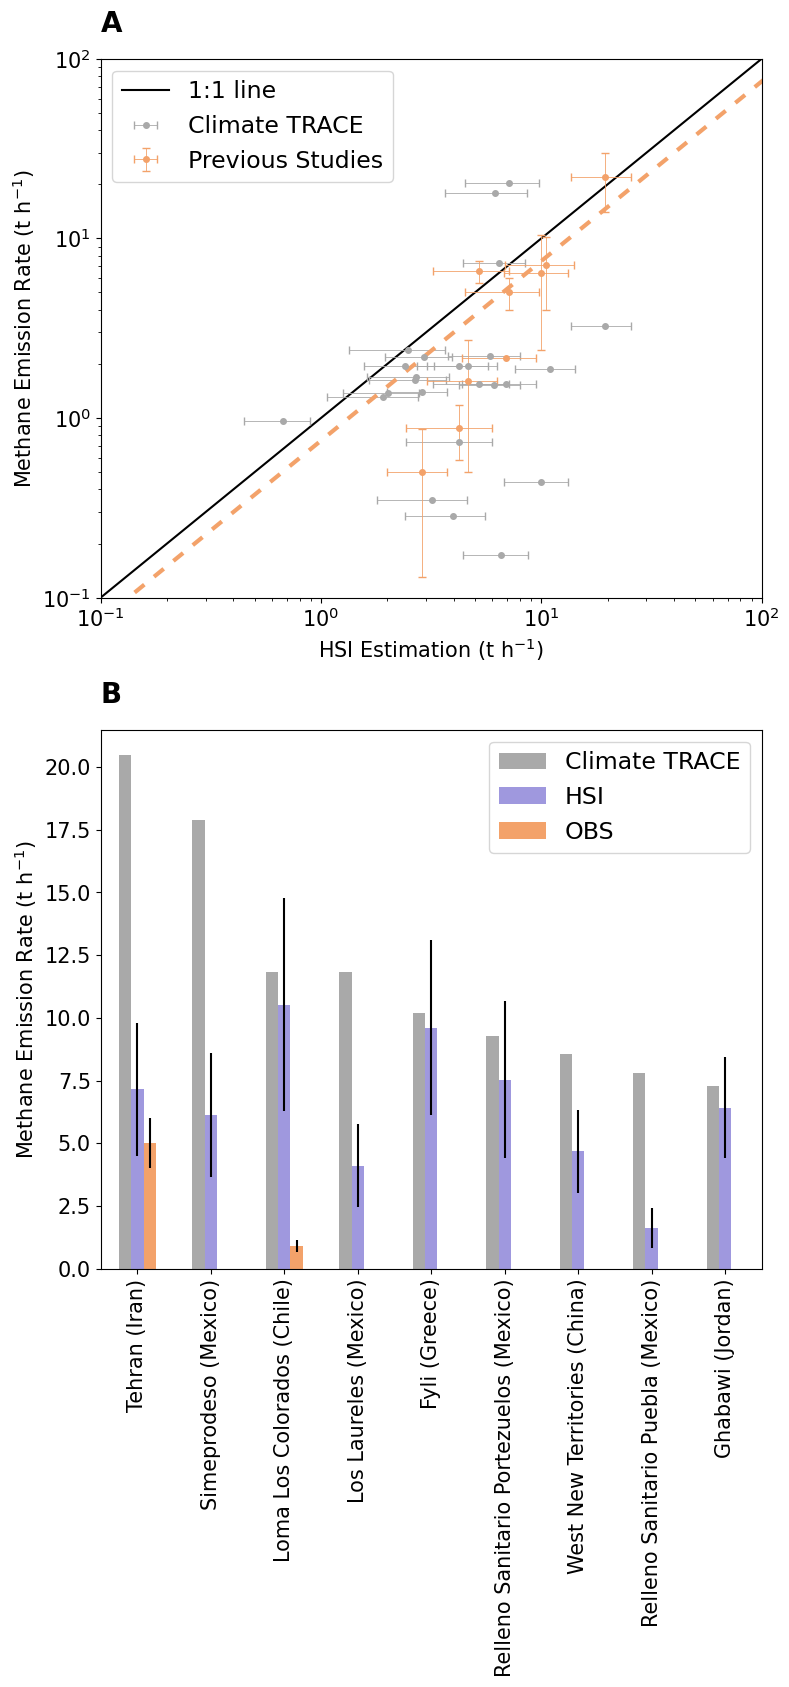

In [52]:
fig, axs = plt.subplots(figsize=(8, 17), nrows=2)

axs = axs.flatten()

ax = axs[0]
l1 = ax.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='k')

# ---- HSI v.s. Climate TRACE ---
x = df_merge_ct['HSI'].values # t/h
xerr = df_merge_ct['HSI uncertainty (t h$^{-1}$)']
y = df_merge_ct['Climate TRACE'].values  # t/h

slope, r_squared = fit_line(x, y, type='OLS')
# slope, r_squared = fit_line(x, y, sx=xerr, type='ODR')
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
mbe = (x-y).mean()
rmse = mean_squared_error(x, y, squared=False)
corr, _ = pearsonr(x, y)
print('HSI v.s. Climate TRACE, slope: ', slope, 'Pearson correlation: ', corr, 'MBE: ', mbe, 'RMSE: ', rmse)

# l2 = ax.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='C0', linestyle='--')
# l2 = ax.axline(xy1=(0, 0), slope=slope, label='Climate TRACE', c='C0', linestyle='--')
# ax.plot(np.arange(300), slope*np.arange(300), label='Climate TRACE', c='darkgray', linestyle='--', dashes=(3, 3), linewidth=3)

# ax.scatter(x, y)
ax.errorbar(x, y, xerr=xerr, c='darkgray', fmt='o', capsize=3, markersize=4, elinewidth=0.6, label='Climate TRACE')

# ---- HSI v.s. OBS ---
x = df_merge_obs_nonan['emission'].values  # t/h
xerr = x * df_merge_obs_nonan['emission_uncertainty(%)'] * 1e-2
y = df_merge_obs_nonan['emission_obs'].values  # t/h
yerr = df_merge_obs_nonan['uncertainty_obs'].values  # t/h

# import statsmodels.formula.api as smf
# model = smf.ols('y~ x - 1', data={'x': x, 'y': y}).fit()
# slope = model.params['x']
# rsquared = model.rsquared

# slope, r_squared = fit_line(x, y, type='RMA')
slope, r_squared = fit_line(x, y, sx=xerr, sy=yerr, type='ODR')
corr, _ = pearsonr(x, y)
mbe = (x-y).mean()
rmse = mean_squared_error(x, y, squared=False)
print('HSI v.s. OBS, slope: ', slope, 'R2: ', r_squared, 'Pearson correlation: ', corr, 'MBE: ', mbe, 'RMSE: ', rmse)
# l3 = ax.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='darkorange', linestyle='--')
# l3 = ax.axline(xy1=(0, 0), slope=slope, label='OBS', c='darkorange', linestyle='--')
l3 = ax.plot(np.arange(300), slope*np.arange(300), c='#f3a26a', linestyle='--', dashes=(3, 3), linewidth=3)
ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', capsize=3, markersize=4, elinewidth=0.6, c='#f3a26a', label='Previous Studies')

# # plot scatter
# def dfScatter(df, ax, xcol='emission', ycol='emission_obs', catcol='type'):
#     categories = np.unique(df[catcol])
#     colors = np.linspace(0, 1, len(categories))
#     colordict = dict(zip(categories, colors))  

#     df["Color"] = df[catcol].apply(lambda x: colordict[x])
#     ax.scatter(df[xcol], df[ycol], c=df.Color, cmap='viridis', s=4, zorder=10)

# dfScatter(df_merge_obs_nonan, ax)

ax.set_xlabel('HSI Estimation (t h$^{-1}$)')
ax.set_ylabel('Methane Emission Rate (t h$^{-1}$)')

ax.legend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, 100)
ax.set_ylim(0.1, 100)

# ---- TOP 20 Climate Trace ----
ax = axs[1]

df_merge_all.plot(ax=ax,
                x='xname', y=['Climate TRACE', 'HSI', 'OBS'],
                yerr=[[0]*len(df_merge_all),
                      df_merge_all['HSI uncertainty (t h$^{-1}$)'],
                        df_merge_all['OBS uncertainty'],
                        ],
                kind="bar",
                # color=['darkgrey', 'C0', 'darkorange'],
                color=['darkgray', '#9f98de', '#f3a26a'],
                rot=90,
                )
ax.set_xlabel('')
ax.set_ylabel('Methane Emission Rate (t h$^{-1}$)')
ax.set_ylim(ymin=0)

for n, ax in enumerate(axs):
    # plot wind quivers
    ax.text(0, 1.05, string.ascii_uppercase[n],
            transform=ax.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
fig.savefig('../figures/emission_comp.pdf')

(0.0, 21.4787448630137)

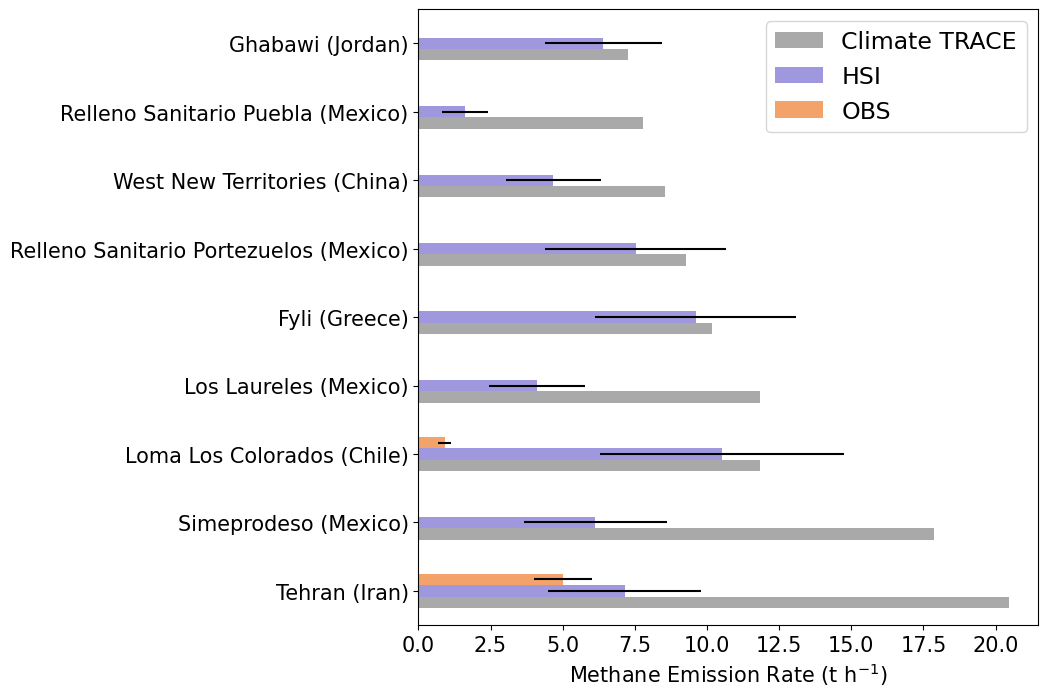

In [53]:
# for ppt
fig, ax = plt.subplots(figsize=(8, 8))
df_merge_all.plot(ax=ax,
                x='xname', y=['Climate TRACE', 'HSI', 'OBS'],
                xerr=[[0]*len(df_merge_all),
                      df_merge_all['HSI uncertainty (t h$^{-1}$)'],
                        df_merge_all['OBS uncertainty'],
                        ],
                kind="barh",
                # color=['darkgrey', 'C0', 'darkorange'],
                color=['darkgray', '#9f98de', '#f3a26a'],
                # rot=90,
                )
ax.set_ylabel('')
ax.set_xlabel('Methane Emission Rate (t h$^{-1}$)')
ax.set_xlim(xmin=0)

In [54]:
# Mean bias and RMSE for landfill hotspot comparison
bias = np.mean(df_merge_obs_nonan['emission'] - df_merge_obs_nonan['emission_obs'])
rmse = mean_squared_error(y_true=df_merge_obs_nonan['emission_obs'], y_pred=df_merge_obs_nonan['emission'], squared=False)
print('Mean bias: ', bias, 'RMSE: ', rmse)

Mean bias:  2.0882455378381204 RMSE:  3.0633122408445623


In [55]:
df_merge_all['hsi_ct_diff_percent'] = (df_merge_all['HSI'] - df_merge_all['Climate TRACE'])/df_merge_all['Climate TRACE']*1e2

In [56]:
df_merge_all

,Country,Name,Climate TRACE,HSI,HSI uncertainty (t h$^{-1}$),OBS,OBS uncertainty,xname,hsi_ct_diff_percent
0,Iran,Tehran,20.455947,7.148717,2.657898,5.00,1.00,Tehran (Iran),-65.053113
1,Mexico,Simeprodeso,17.866376,6.133552,2.478513,NaN,NaN,Simeprodeso (Mexico),-65.669861
2,Chile,Loma Los Colorados,11.830760,10.528896,4.231341,0.91,0.23,Loma Los Colorados (Chile),-11.004063
3,Mexico,Los Laureles,11.826663,4.106266,1.665626,NaN,NaN,Los Laureles (Mexico),-65.279589
4,Greece,Fyli,10.184733,9.605749,3.484910,NaN,NaN,Fyli (Greece),-5.684823
5,Mexico,Relleno Sanitario Portezuelos,9.266826,7.530332,3.129445,NaN,NaN,Relleno Sanitario Portezuelos (Mexico),-18.738824
6,China,West New Territories,8.553950,4.675885,1.642292,NaN,NaN,West New Territories (China),-45.336544
7,Mexico,Relleno Sanitario Puebla,7.794032,1.610092,0.802766,NaN,NaN,Relleno Sanitario Puebla (Mexico),-79.341982
8,Jordan,Ghabawi,7.268989,6.413196,2.013398,NaN,NaN,Ghabawi (Jordan),-11.773198
